<h1> Create Keras DNN model </h1>

This notebook illustrates:
<ol>
<li> Creating a model using Keras. This requires TensorFlow 2.1
</ol>

In [1]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.5

tensorflow==2.5.0


In [2]:
# change these to try this notebook out
BUCKET = 'dev-xai-natality'
PROJECT = 'hack4ssb-team1'
REGION = 'europe-west3'

In [3]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [4]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [5]:
%%bash
ls *.csv

eval.csv
train.csv


## Create Keras model
<p>
First, write an input_fn to read the data.

In [6]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

2021-09-30 07:53:48.199055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 07:53:48.199095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.0


In [7]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column. Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

In [8]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

Next, define the feature columns. mother_age and gestation_weeks should be numeric.
The others (is_male, plurality) should be categorical.

In [9]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Helper function to handle categorical columns
def categorical_fc(name, values):
  return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(name, values))

def build_dnn_model():
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in ['mother_age', 'gestation_weeks', 'is_male', 'plurality']
    }

    # feature columns from inputs
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
            for colname in ['mother_age', 'gestation_weeks', 'is_male', 'plurality']
    }

    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(32, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='babyweight')(h2)
    

    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])    
    return model

print("Here is our DNN architecture so far:\n")

# note how to use strategy to do distributed training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2021-09-30 07:53:52.692727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-30 07:53:52.692775: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-30 07:53:52.692802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20210928-115710): /proc/driver/nvidia/version does not exist
2021-09-30 07:53:52.722415: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            0                                            
______________________________________________________________________________________________

We can visualize the DNN using the Keras plot_model utility.

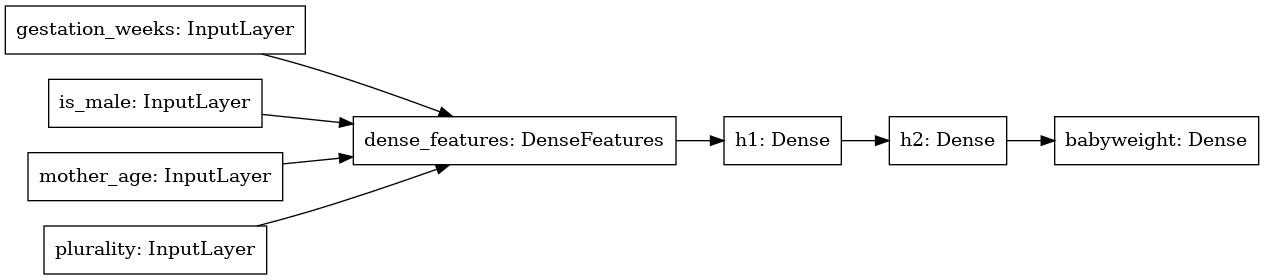

In [10]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train and evaluate

In [11]:
TRAIN_BATCH_SIZE = 64
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 30  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('eval*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

2021-09-30 07:54:07.850504: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "LegacyParallelInterleaveDatasetV2/_11"
op: "LegacyParallelInterleaveDatasetV2"
input: "ShuffleDatasetV3/_6"
input: "Const/_2"
input: "Const/_2"
input: "Const/_9"
input: "Const/_9"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "deterministic"
  value {
    s: "true"
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_tf_data_experimental_parallel_interleave_filename_to_dataset_185"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: D

Epoch 1/30
 1/26 [>.............................] - ETA: 1:46 - loss: 67.3857 - rmse: 8.2089 - mse: 67.3857

2021-09-30 07:54:12.485859: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "LegacyParallelInterleaveDatasetV2/_11"
op: "LegacyParallelInterleaveDatasetV2"
input: "ShuffleDatasetV3/_6"
input: "Const/_7"
input: "Const/_7"
input: "Const/_9"
input: "Const/_9"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "deterministic"
  value {
    s: "true"
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_tf_data_experimental_parallel_interleave_filename_to_dataset_266"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: D

26/26 [==============================] - 5s 39ms/step - loss: 10.2136 - rmse: 2.6945 - mse: 10.2136 - val_loss: 2.9041 - val_rmse: 1.7037 - val_mse: 2.9041
Epoch 2/30
26/26 [==============================] - 1s 20ms/step - loss: 1.7179 - rmse: 1.2970 - mse: 1.7179 - val_loss: 1.3697 - val_rmse: 1.1696 - val_mse: 1.3697
Epoch 3/30
26/26 [==============================] - 1s 21ms/step - loss: 1.4017 - rmse: 1.1799 - mse: 1.4017 - val_loss: 1.3392 - val_rmse: 1.1567 - val_mse: 1.3392
Epoch 4/30
26/26 [==============================] - 0s 19ms/step - loss: 1.3174 - rmse: 1.1412 - mse: 1.3174 - val_loss: 1.2997 - val_rmse: 1.1398 - val_mse: 1.2997
Epoch 5/30
26/26 [==============================] - 0s 19ms/step - loss: 1.3831 - rmse: 1.1656 - mse: 1.3831 - val_loss: 1.3044 - val_rmse: 1.1419 - val_mse: 1.3044
Epoch 6/30
26/26 [==============================] - 0s 19ms/step - loss: 1.2454 - rmse: 1.1094 - mse: 1.2454 - val_loss: 1.3162 - val_rmse: 1.1467 - val_mse: 1.3162
Epoch 7/30
26/26 [=

## Visualize loss curve

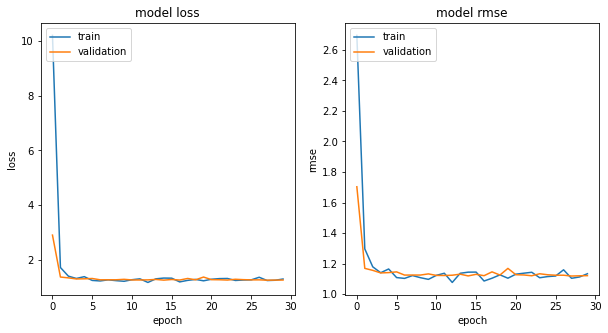

In [12]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Save the model

Let's wrap the model so that we can supply keyed predictions, and get the key back in our output

In [13]:
# Serving function that passes through keys
@tf.function(input_signature=[{
      'is_male': tf.TensorSpec([None,], dtype=tf.string, name='is_male'),
      'mother_age': tf.TensorSpec([None,], dtype=tf.float32, name='mother_age'),
      'plurality': tf.TensorSpec([None,], dtype=tf.string, name='plurality'),
      'gestation_weeks': tf.TensorSpec([None,], dtype=tf.float32, name='gestation_weeks'),
      'key': tf.TensorSpec([None,], dtype=tf.string, name='key')
}])
def my_serve(inputs):
    feats = inputs.copy()
    key = feats.pop('key')
    output = model(feats)
    return {'key': key, 'babyweight': output}

In [14]:
import shutil, os, datetime
OUTPUT_DIR = './export/babyweight'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH, signatures={'serving_default': my_serve})
print("Exported trained model to {}".format(EXPORT_PATH))
os.environ['EXPORT_PATH'] = EXPORT_PATH

2021-09-30 07:54:40.934449: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./export/babyweight/20210930075440/assets
Exported trained model to ./export/babyweight/20210930075440


In [15]:
!find $EXPORT_PATH

./export/babyweight/20210930075440
./export/babyweight/20210930075440/variables
./export/babyweight/20210930075440/variables/variables.index
./export/babyweight/20210930075440/variables/variables.data-00000-of-00001
./export/babyweight/20210930075440/saved_model.pb
./export/babyweight/20210930075440/assets


## Deploy trained model to Cloud AI Platform


In [16]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

2021-09-30 07:54:58.683424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 07:54:58.683469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
The given SavedModel SignatureDef contains the following input(s):
  inputs['gestation_weeks'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_gestation_weeks:0
  inputs['is_male'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_is_male:0
  inputs['key'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_key:0
  inputs['mother_age'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_mother_age:0
  inputs['plurality'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      nam

In [17]:
EXPLAIN_METHOD = "integrated-gradients"
os.environ['EXPLAIN_METHOD'] = EXPLAIN_METHOD

In [22]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
builder = SavedModelMetadataBuilder(EXPORT_PATH, outputs_to_explain=["babyweight"])
print(model.input)
builder.set_numeric_metadata(
    model.input.name.split(':')[0],
    input_baselines=[trainds.median().values.tolist()],
    index_feature_mapping=trainds.columns.tolist()
)
builder.save_metadata(EXPORT_PATH)

{'mother_age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'mother_age')>, 'gestation_weeks': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'gestation_weeks')>, 'is_male': <KerasTensor: shape=(None,) dtype=string (created by layer 'is_male')>, 'plurality': <KerasTensor: shape=(None,) dtype=string (created by layer 'plurality')>}


AttributeError: 'dict' object has no attribute 'name'

In [24]:
%%bash
MODEL_NAME="babyweight"
VERSION_NAME="dnn"
MODEL_LOCATION=$EXPORT_PATH
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

if [[ $(gcloud ai-platform models list --region $REGION --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "The model named $MODEL_NAME already exists."
else
    # create model
    echo "Creating $MODEL_NAME model now."
    gcloud ai-platform models create --enable-logging --region $REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --region $REGION --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already the existing model $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --enable-logging --model=$MODEL_NAME $VERSION_NAME --region $REGION
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud beta ai-platform versions create $VERSION_NAME --async \
--region $REGION \
--model $MODEL_NAME \
--runtime-version 2.5 \
--framework TENSORFLOW \
--python-version 3.7 \
--origin $MODEL_LOCATION \
--staging-bucket gs://$BUCKET \
--machine-type n1-standard-4 \
--explanation-method $EXPLAIN_METHOD \
--num-integral-steps 25

Deleting and deploying babyweight  from ./export/babyweight/20210929145143 ... this will take a few minutes
The model named babyweight already exists.
Creating babyweight:dnn


Using endpoint [https://europe-west3-ml.googleapis.com/]
Using endpoint [https://europe-west3-ml.googleapis.com/]
Using endpoint [https://europe-west3-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
ERROR: (gcloud.beta.ai-platform.versions.create) FAILED_PRECONDITION: Field: version.deployment_uri Error: Model deployment failed: unable to read explanation_metadata.json with user credentials under deployment directory gs://dev-xai-natality/328cac1b485b045a2912fab0372a488d18250c111a5c725bba58afcc10b7277e/.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: 'Model deployment failed: unable to read explanation_metadata.json
      with user credentials under deployment directory gs://dev-xai-natality/328cac1b485b045a2912fab0372a488d18250c111a5c725bba58afcc10b7277

CalledProcessError: Command 'b'MODEL_NAME="babyweight"\nVERSION_NAME="dnn"\nMODEL_LOCATION=$EXPORT_PATH\necho "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"\n\nif [[ $(gcloud ai-platform models list --region $REGION --format=\'value(name)\' | grep $MODEL_NAME) ]]; then\n    echo "The model named $MODEL_NAME already exists."\nelse\n    # create model\n    echo "Creating $MODEL_NAME model now."\n    gcloud ai-platform models create --enable-logging --region $REGION $MODEL_NAME\nfi\n\nif [[ $(gcloud ai-platform versions list --region $REGION --model $MODEL_NAME --format=\'value(name)\' | grep $VERSION_NAME) ]]; then\n    echo "Deleting already the existing model $MODEL_NAME:$VERSION_NAME ... "\n    gcloud ai-platform versions delete --enable-logging --model=$MODEL_NAME $VERSION_NAME --region $REGION\n    echo "Please run this cell again if you don\'t see a Creating message ... "\n    sleep 2\nfi\n\n# create model\necho "Creating $MODEL_NAME:$VERSION_NAME"\ngcloud beta ai-platform versions create $VERSION_NAME --async \\\n--region $REGION \\\n--model $MODEL_NAME \\\n--runtime-version 2.5 \\\n--framework TENSORFLOW \\\n--python-version 3.7 \\\n--origin $MODEL_LOCATION \\\n--staging-bucket gs://$BUCKET \\\n--machine-type n1-standard-4 \\\n--explanation-method $EXPLAIN_METHOD \\\n--num-integral-steps 25\n'' returned non-zero exit status 1.

Monitor the model creation at [GCP Console > AI Platform](https://console.cloud.google.com/mlengine/models/taxifare/) and once the model version `dnn` is created, proceed to the next cell.


In [ ]:
%%writefile input.json
{"key": "b1", "is_male": "True", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "b2", "is_male": "True", "mother_age": 33.0, "plurality": "Single(1)", "gestation_weeks": 41}
{"key": "g1", "is_male": "False", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "g2", "is_male": "False", "mother_age": 33.0, "plurality": "Single(1)", "gestation_weeks": 41}

In [ ]:
!gcloud ai-platform predict --model babyweight --json-instances input.json --version dnn

## main.py

This is the code that exists in [serving/application/main.py](serving/application/main.py), i.e. the code in the web application that accesses the ML API.

In [ ]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)
project = PROJECT
model_name = 'babyweight'
version_name = 'dnn'

input_data = {
  'instances': [
    {
      'key': 'b1',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'key': 'g1',
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
    {
      'key': 'b2',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Triplets(3)',
      'gestation_weeks': 39
    },
    {
      'key': 'u1',
      'is_male': 'Unknown',
      'mother_age': 29.0,
      'plurality': 'Multiple(2+)',
      'gestation_weeks': 38
    },
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (project, model_name, version_name)
prediction = api.projects().predict(body=input_data, name=parent).execute()

print(prediction)
print(prediction['predictions'][0]['babyweight'][0])

In [ ]:
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT, MODEL_NAME, VERSION_NAME, region=REGION)
ig_response = remote_ig_model.explain(instances)
ig_response[0].visualize_attributions()

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License